In [ ]:
import pandas as pd
from datasets import load_dataset
import re
import os
from datasets import Dataset

from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer
)
import torch
import numpy as np
from sklearn.metrics import accuracy_score, f1_score

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install -U datasets fsspec huggingface_hub


  Using cached fsspec-2025.5.1-py3-none-any.whl.metadata (11 kB)


In [ ]:
def clean_text(text):
    """
    A simple text cleaning function to remove URLs, mentions, hashtags,
    and non-Arabic/English characters, except for basic punctuation.
    """
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Remove user @ mentions
    text = re.sub(r'\@\w+', '', text)
    # Remove hashtags
    text = re.sub(r'#', '', text)
    # Remove most non-alphanumeric characters (keeps Arabic, English, and numbers)
    text = re.sub(r'[^\u0600-\u06FF\u0750-\u077F\u08A0-\u08FFa-zA-Z0-9\s]', '', text)
    # Remove extra whitespace
    text = " ".join(text.split())
    return text.strip()

In [ ]:
from huggingface_hub import login

login()

In [ ]:
print("Downloading the Egyptian Arabic Hate Speech dataset from Hugging Face...")

# 1. Load the dataset
dataset = load_dataset("IbrahimAmin/egyptian-arabic-hate-speech")

print("Dataset downloaded successfully. Processing now...")

train_df = dataset['train'].to_pandas()
test_df = dataset['test'].to_pandas()

train_df


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/420k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/108k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/6535 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1634 [00:00<?, ? examples/s]

Dataset downloaded successfully. Processing now...


,text,label
0,انت في قمه النداله,Offensive
1,يلعن دين المسلمين ويلعن دين الحركه الاسلاميه ك...,Religious Discrimination
2,عيل زنجي عبد ابن كلب مشافش تربيه,Racism
3,كسم ليبيا والعراق واللي منهم إرهابيين ولاد وسخة,Racism
4,بضان بضان يعني مفيش كلام,Offensive
...,...,...
6530,الكفاتسه ريحتهم تقرف من كتر الخمره اللي بيشربو...,Religious Discrimination
6531,يخربيت كدبك كداب اكتر من ابليس,Offensive
6532,غور من هنا ياه زنجي وانت شبه الفحمه كده,Racism
6533,انت عايز تولع في دين ابو البلد وخلاص وعمال تلغ...,Offensive


In [ ]:
train_df['label'].unique()

array(['Offensive', 'Religious Discrimination', 'Racism', 'Sexism',
       'Neutral'], dtype=object)

In [ ]:

train_df['label'] = np.where(train_df['label'] == 'Neutral', 0, 1)
test_df['label'] = np.where(test_df['label'] == 'Neutral', 0, 1)

print("Train DataFrame labels after conversion:")
print(train_df['label'].value_counts())
print("\nTest DataFrame labels after conversion:")
print(test_df['label'].value_counts())

Train DataFrame labels after conversion:
label
1    4827
0    1708
Name: count, dtype: int64

Test DataFrame labels after conversion:
label
1    1207
0     427
Name: count, dtype: int64


In [ ]:
MODEL_NAME_1 = "aubmindlab/bert-base-arabertv2"
OUTPUT_DIR_1= "/content/drive/My Drive/aubmindlab"

print(f"Loading tokenizer and model for '{MODEL_NAME_1}'...")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME_1)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME_1, num_labels=2)


Loading tokenizer and model for 'aubmindlab/bert-base-arabertv2'...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at aubmindlab/bert-base-arabertv2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

print("Tokenizing datasets...")
def tokenize_function(examples):
        # The tokenizer will pad and truncate the text to a standard length
        return tokenizer(examples["text"], padding="max_length", truncation=True)

tokenized_train_dataset = train_dataset.map(tokenize_function, batched=True)
tokenized_test_dataset = test_dataset.map(tokenize_function, batched=True)


Tokenizing datasets...


Map:   0%|          | 0/6535 [00:00<?, ? examples/s]

Map:   0%|          | 0/1634 [00:00<?, ? examples/s]

In [ ]:
def compute_metrics(p):
        preds = np.argmax(p.predictions, axis=1)
        accuracy = accuracy_score(p.label_ids, preds)
        f1 = f1_score(p.label_ids, preds, average='weighted')
        return {
            'accuracy': accuracy,
            'f1': f1,
        }

In [ ]:
training_args = TrainingArguments(
        output_dir=OUTPUT_DIR_1,
        num_train_epochs=2,  # A good starting point is 2-3 epochs
        per_device_train_batch_size=16, # Adjust based on your GPU memory
        per_device_eval_batch_size=16,
        warmup_steps=500,
        weight_decay=0.01,
        logging_dir='./logs',
        logging_steps=10,
        eval_strategy="epoch", # Corrected argument name
        save_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="f1",
    )

trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_train_dataset,
        eval_dataset=tokenized_test_dataset,
        compute_metrics=compute_metrics,
    )

In [ ]:
print("\n--- Starting Model Training ---")
trainer.train()
print("--- Training Finished ---")

# 8. Save the final model and tokenizer
print(f"Saving the fine-tuned model to '{OUTPUT_DIR_1}'...")
trainer.save_model(OUTPUT_DIR_1)
tokenizer.save_pretrained(OUTPUT_DIR_1)
print("Model saved successfully!")


--- Starting Model Training ---


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.477000,0.222570,0.917381,0.915535
2,0.108800,0.212897,0.933905,0.933954


--- Training Finished ---
Saving the fine-tuned model to '/content/drive/My Drive/aubmindlab'...
Model saved successfully!


In [ ]:
MODEL_NAME_2 = "UBC-NLP/MARBERT"
OUTPUT_DIR_2= "/content/drive/My Drive/MARBERT"

print(f"Loading tokenizer and model for '{MODEL_NAME_2}'...")
tokenizer_2 = AutoTokenizer.from_pretrained(MODEL_NAME_2)
model_2 = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME_2, num_labels=2)


Loading tokenizer and model for 'UBC-NLP/MARBERT'...


tokenizer_config.json:   0%|          | 0.00/376 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/701 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/654M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/654M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at UBC-NLP/MARBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
def tokenize_function(examples):
        # The tokenizer will pad and truncate the text to a standard length
        return tokenizer_2(examples["text"], padding="max_length", truncation=True)

tokenized_train_dataset = train_dataset.map(tokenize_function, batched=True)
tokenized_test_dataset = test_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/6535 [00:00<?, ? examples/s]

Map:   0%|          | 0/1634 [00:00<?, ? examples/s]

In [ ]:
tokenized_train_dataset[0]

{'text': 'انت في قمه النداله',
 'label': 1,
 'input_ids': [33,
  442,
  289,
  1462,
  223,
  11154,
  16730,
  223,
  34,
  31,
  31,
  31,
  31,
  31,
  31,
  31,
  31,
  31,
  31,
  31,
  31,
  31,
  31,
  31,
  31,
  31,
  31,
  31,
  31,
  31,
  31,
  31,
  31,
  31,
  31,
  31,
  31,
  31,
  31,
  31,
  31,
  31,
  31,
  31,
  31,
  31,
  31,
  31,
  31,
  31,
  31,
  31,
  31,
  31,
  31,
  31,
  31,
  31,
  31,
  31,
  31,
  31,
  31,
  31,
  31,
  31,
  31,
  31,
  31,
  31,
  31,
  31,
  31,
  31,
  31,
  31,
  31,
  31,
  31,
  31,
  31,
  31,
  31,
  31,
  31,
  31,
  31,
  31,
  31,
  31,
  31,
  31,
  31,
  31,
  31,
  31,
  31,
  31,
  31,
  31,
  31,
  31,
  31,
  31,
  31,
  31,
  31,
  31,
  31,
  31,
  31,
  31,
  31,
  31,
  31,
  31,
  31,
  31,
  31,
  31,
  31,
  31,
  31,
  31,
  31,
  31,
  31,
  31,
  31,
  31,
  31,
  31,
  31,
  31,
  31,
  31,
  31,
  31,
  31,
  31,
  31,
  31,
  31,
  31,
  31,
  31,
  31,
  31,
  31,
  31,
  31,
  31,
  31,
  31,
  31,
 

In [ ]:
training_args = TrainingArguments(
        output_dir=OUTPUT_DIR_2,
        num_train_epochs=2,  # A good starting point is 2-3 epochs
        per_device_train_batch_size=16, # Adjust based on your GPU memory
        per_device_eval_batch_size=16,
        warmup_steps=500,
        weight_decay=0.01,
        logging_dir='./logs',
        logging_steps=10,
        eval_strategy="epoch", # Corrected argument name
        save_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="f1",
    )

trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_train_dataset,
        eval_dataset=tokenized_test_dataset,
        compute_metrics=compute_metrics,
    )

In [ ]:
print("\n--- Starting Model Training ---")
trainer.train()
print("--- Training Finished ---")

# 8. Save the final model and tokenizer
print(f"Saving the fine-tuned model to '{OUTPUT_DIR_2}'...")
trainer.save_model(OUTPUT_DIR_2)
tokenizer.save_pretrained(OUTPUT_DIR_2)
print("Model saved successfully!")

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.



--- Starting Model Training ---


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: mohamed-sayed-99011 (mohamed-sayed-99011-nile-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.342700,0.199151,0.919217,0.918173
2,0.150800,0.201090,0.940024,0.940159


--- Training Finished ---
Saving the fine-tuned model to '/content/drive/My Drive/MARBERT'...
Model saved successfully!


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at aubmindlab/bert-base-arabertv2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Device set to use cuda:0



📊 Evaluation for (Base AraBERT):
Accuracy: 0.7178702570379437
F1-Score: 0.8319358366751731
              precision    recall  f1-score   support

           0       0.33      0.07      0.12       427
           1       0.74      0.95      0.83      1207

    accuracy                           0.72      1634
   macro avg       0.53      0.51      0.48      1634
weighted avg       0.63      0.72      0.65      1634



Device set to use cuda:0



📊 Evaluation for (Fine-Tuned AraBERT):
Accuracy: 0.9339045287637698
F1-Score: 0.9552238805970149
              precision    recall  f1-score   support

           0       0.87      0.88      0.87       427
           1       0.96      0.95      0.96      1207

    accuracy                           0.93      1634
   macro avg       0.91      0.92      0.91      1634
weighted avg       0.93      0.93      0.93      1634



config.json:   0%|          | 0.00/701 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/654M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at UBC-NLP/MARBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.safetensors:   0%|          | 0.00/654M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/376 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Device set to use cuda:0



📊 Evaluation for (Base MARBERT):
Accuracy: 0.5991432068543452
F1-Score: 0.734925131525698
              precision    recall  f1-score   support

           0       0.19      0.17      0.18       427
           1       0.72      0.75      0.73      1207

    accuracy                           0.60      1634
   macro avg       0.46      0.46      0.46      1634
weighted avg       0.58      0.60      0.59      1634



Device set to use cuda:0



📊 Evaluation for (Fine-Tuned MARBERT):
Accuracy: 0.9400244798041616
F1-Score: 0.9593023255813954
              precision    recall  f1-score   support

           0       0.88      0.89      0.89       427
           1       0.96      0.96      0.96      1207

    accuracy                           0.94      1634
   macro avg       0.92      0.92      0.92      1634
weighted avg       0.94      0.94      0.94      1634



config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/651M [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

Device set to use cuda:0



📊 Evaluation for (External Fine-Tuned MARBERT):
Accuracy: 0.7386780905752754
F1-Score: 0.8497008095740937
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       427
           1       0.74      1.00      0.85      1207

    accuracy                           0.74      1634
   macro avg       0.37      0.50      0.42      1634
weighted avg       0.55      0.74      0.63      1634


✅ Results saved to 'evaluation_results.csv'


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


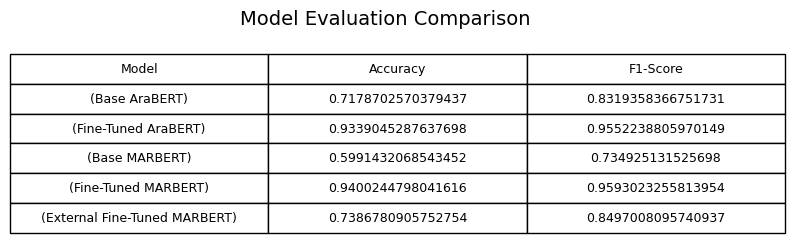

In [ ]:
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, accuracy_score, f1_score
from transformers import pipeline, AutoModelForSequenceClassification, AutoTokenizer

# Initialize a list to hold results
results = []

# Wrap evaluation in a function that also saves metrics
def evaluate_model(model, tokenizer, name):
    pipe = pipeline("text-classification", model=model, tokenizer=tokenizer, device=0 if torch.cuda.is_available() else -1)
    preds = pipe(test_df['text'].tolist(), truncation=True, max_length=256)
    pred_labels = [0 if p['label'].lower() == 'label_0' else 1 for p in preds]

    acc = accuracy_score(test_df['label'], pred_labels)
    f1 = f1_score(test_df['label'], pred_labels)

    # Print summary
    print(f"\n📊 Evaluation for {name}:")
    print("Accuracy:", acc)
    print("F1-Score:", f1)
    print(classification_report(test_df['label'], pred_labels))

    # Save to results list
    results.append({"Model": name, "Accuracy": acc, "F1-Score": f1})

# Model 1A: Pretrained only
model_1a = AutoModelForSequenceClassification.from_pretrained("aubmindlab/bert-base-arabertv2", num_labels=2)
tokenizer_1a = AutoTokenizer.from_pretrained("aubmindlab/bert-base-arabertv2")
evaluate_model(model_1a, tokenizer_1a, "(Base AraBERT)")

# Model 1B: Fine-tuned version
OUTPUT_DIR_1 = "/content/drive/MyDrive/Models/aubmindlab"
model_1b = AutoModelForSequenceClassification.from_pretrained(OUTPUT_DIR_1)
tokenizer_1b = AutoTokenizer.from_pretrained(OUTPUT_DIR_1)
evaluate_model(model_1b, tokenizer_1b, "(Fine-Tuned AraBERT)")

# Model 2A: Second base model (replace with your actual second model name)
model_2a = AutoModelForSequenceClassification.from_pretrained("UBC-NLP/MARBERT", num_labels=2)
tokenizer_2a = AutoTokenizer.from_pretrained("UBC-NLP/MARBERT")
evaluate_model(model_2a, tokenizer_2a, "(Base MARBERT)")

# Model 2B: Fine-tuned version (you must set this folder correctly)
OUTPUT_DIR_2= "/content/drive/MyDrive/Models/MARBERT"
model_2b = AutoModelForSequenceClassification.from_pretrained(OUTPUT_DIR_2)
tokenizer_2b = AutoTokenizer.from_pretrained(OUTPUT_DIR_2)
evaluate_model(model_2b, tokenizer_2b, "(Fine-Tuned MARBERT)")

model_c = AutoModelForSequenceClassification.from_pretrained("IbrahimAmin/marbertv2-finetuned-egyptian-hate-speech-classification")
tokenizer_1c = AutoTokenizer.from_pretrained("IbrahimAmin/marbertv2-finetuned-egyptian-hate-speech-classification")
evaluate_model(model_c, tokenizer_1c, "(External Fine-Tuned MARBERT)")

# Convert to DataFrame and export as CSV
df_results = pd.DataFrame(results)
df_results.to_csv("evaluation_results.csv", index=False)
print("\n✅ Results saved to 'evaluation_results.csv'")


# Create figure and axis
fig, ax = plt.subplots(figsize=(10, 2))
ax.axis('off')

# Add title manually as a separate text box
fig.text(0.5, 1.05, "Model Evaluation Comparison", ha='center', fontsize=14)

# Create the table
table = ax.table(
    cellText=df_results.values,
    colLabels=df_results.columns,
    cellLoc='center',
    loc='center'
)
table.scale(1, 2)

# Adjust layout so title doesn't overlap
plt.subplots_adjust(top=0.8)
fig.savefig("model_comparison_table.png", bbox_inches='tight')
plt.show()

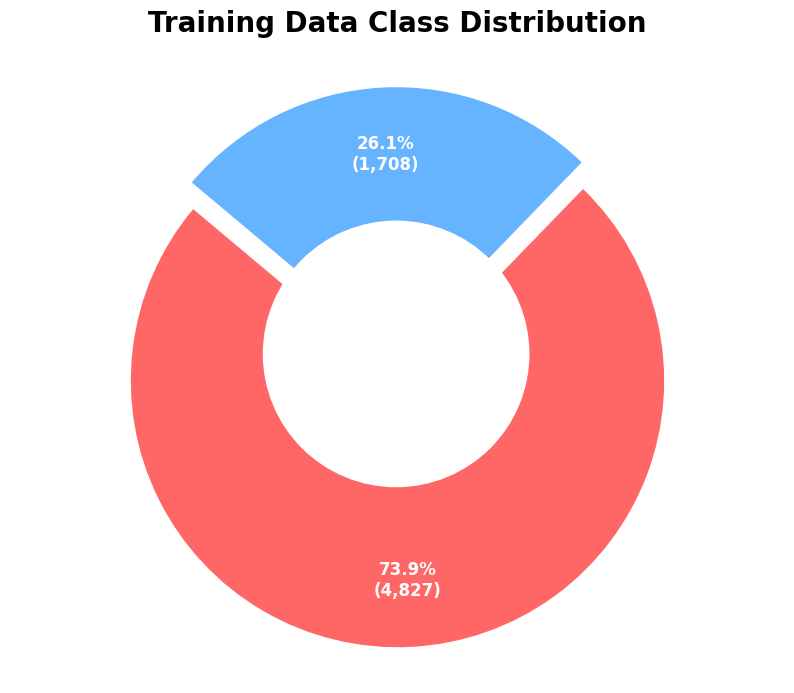

In [1]:
import matplotlib.pyplot as plt
import pandas as pd

# Data based on the class distribution from your notebook
# HATE (Label 1): 4827
# NOT_HATE (Label 0): 1708
labels = ['Hate (Offensive, Racism, etc.)', 'Not Hate (Neutral)']
sizes = [4827, 1708]
colors = ['#ff6666', '#66b3ff']  # Light red for hate, light blue for not hate
explode = (0.1, 0)  # "Explode" the 1st slice (Hate) to highlight it

# Create the figure and axes for the plot
fig, ax = plt.subplots(figsize=(10, 8))

# Create the pie chart
wedges, texts, autotexts = ax.pie(sizes,
                                  explode=explode,
                                  labels=labels,
                                  colors=colors,
                                  autopct=lambda pct: f"{pct:.1f}%\n({int(round(pct/100*sum(sizes))):,})",
                                  startangle=140,
                                  pctdistance=0.75,
                                  textprops=dict(color="w", size=14, weight="bold"))

# Draw a circle at the center to make it a donut chart
centre_circle = plt.Circle((0,0),0.50,fc='white')
fig.gca().add_artist(centre_circle)

# Set the title for the chart
ax.set_title("Training Data Class Distribution", fontsize=20, pad=20, weight="bold")

# Equal aspect ratio ensures that pie is drawn as a circle.
ax.axis('equal')

# Improve the label layout
plt.setp(autotexts, size=12, weight="bold", color="white")
plt.setp(texts, size=14)

# Display the chart
plt.show()

# To save the chart to a file, you can uncomment the following line:
# fig.savefig('class_distribution_pie_chart.png', bbox_inches='tight', dpi=300)



/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127991 (\N{LABEL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128218 (\N{BOOKS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128737 (\N{SHIELD}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


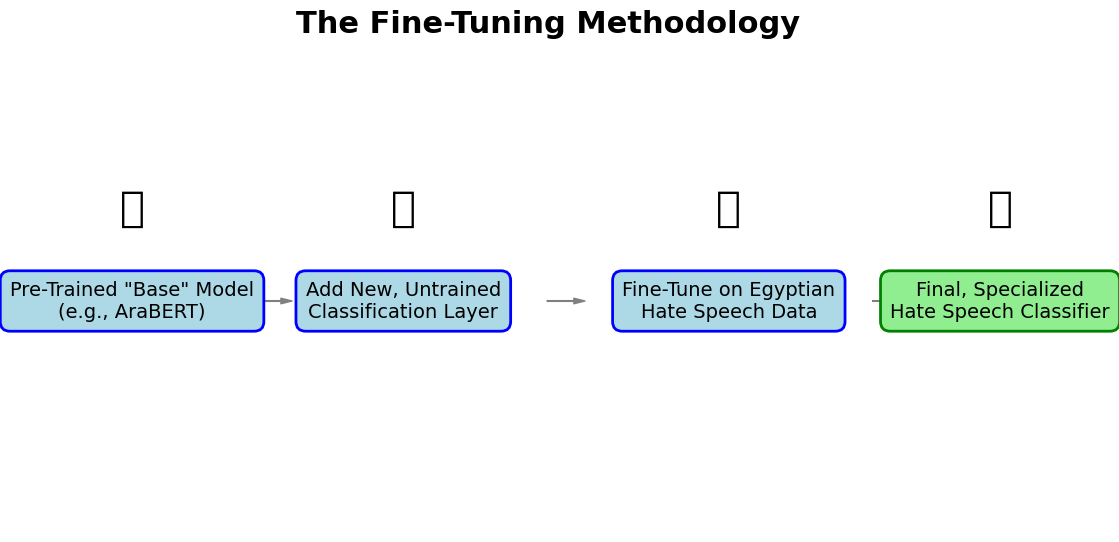

In [2]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Create a figure and axis
fig, ax = plt.subplots(figsize=(14, 6))

# --- Define elements ---
box_style = dict(boxstyle='round,pad=0.5', fc='lightblue', ec='b', lw=2)
arrow_style = dict(arrowstyle='Simple,tail_width=0.5,head_width=4,head_length=8', color='gray')

# Box 1: Pre-Trained Model
ax.text(0.1, 0.5, 'Pre-Trained "Base" Model\n(e.g., AraBERT)', ha='center', va='center',
        bbox=box_style, fontsize=14, wrap=True)
ax.text(0.1, 0.7, '🧠', ha='center', va='center', fontsize=30) # Brain icon

# Box 2: Add Classification Layer
ax.text(0.35, 0.5, 'Add New, Untrained\nClassification Layer', ha='center', va='center',
        bbox=box_style, fontsize=14, wrap=True)
ax.text(0.35, 0.7, '🏷️', ha='center', va='center', fontsize=30) # Tag icon

# Box 3: Fine-Tune
ax.text(0.65, 0.5, 'Fine-Tune on Egyptian\nHate Speech Data', ha='center', va='center',
        bbox=box_style, fontsize=14, wrap=True)
ax.text(0.65, 0.7, '📚', ha='center', va='center', fontsize=30) # Dataset icon

# Box 4: Final Specialized Model
ax.text(0.9, 0.5, 'Final, Specialized\nHate Speech Classifier', ha='center', va='center',
        bbox=dict(boxstyle='round,pad=0.5', fc='lightgreen', ec='g', lw=2), fontsize=14, wrap=True)
ax.text(0.9, 0.7, '🛡️', ha='center', va='center', fontsize=30) # Shield icon

# --- Draw Arrows ---
# Arrow from Box 1 to Box 2
arrow1 = patches.FancyArrowPatch((0.2, 0.5), (0.25, 0.5), **arrow_style)
ax.add_patch(arrow1)

# Arrow from Box 2 to Box 3
arrow2 = patches.FancyArrowPatch((0.48, 0.5), (0.52, 0.5), **arrow_style)
ax.add_patch(arrow2)

# Arrow from Box 3 to Box 4
arrow3 = patches.FancyArrowPatch((0.78, 0.5), (0.82, 0.5), **arrow_style)
ax.add_patch(arrow3)

# --- Final Touches ---
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.axis('off') # Hide the axes
fig.suptitle("The Fine-Tuning Methodology", fontsize=22, fontweight='bold')
plt.show()

# To save the chart to a file, you can uncomment the following line:
# fig.savefig('methodology_flowchart.png', bbox_inches='tight', dpi=300)
